In [1]:
using Revise
using Turing, MCMCChains
using XLSX
using DataFrames, TimeSeries
using StatsPlots
using LinearAlgebra
using CSV
using StatsBase
include("utils.jl")
include("financial_bvar_temp.jl")
using .FinancialBVAR

In [228]:
df = DataFrame(XLSX.readtable("usa_var_data.xlsx", "Data", infer_eltypes=true))
data_source = collapse(TimeArray(df; timestamp = :Date), month, last)

872×11 TimeArray{Float64, 2, Date, Matrix{Float64}} 1951-12-01 to 2024-07-01
┌────────────┬──────────┬───────────┬─────────────┬──────────┬─────────┬────────
│            │ Yeld_10Y │ Price_10Y │ Stock_Price │ Dividend │ E       │ CAPE  ⋯
├────────────┼──────────┼───────────┼─────────────┼──────────┼─────────┼────────
│ 1951-12-01 │  0.02513 │   104.098 │       24.19 │  1.41333 │    2.44 │ 12.52 ⋯
│ 1952-01-01 │  0.02463 │   104.771 │       23.75 │  1.41667 │ 2.42667 │ 12.36 ⋯
│ 1952-02-01 │  0.02617 │   103.585 │       23.81 │     1.42 │ 2.41333 │ 12.36 ⋯
│ 1952-03-01 │  0.02505 │   104.824 │       23.74 │     1.43 │     2.4 │ 12.24 ⋯
│ 1952-04-01 │  0.02422 │   105.806 │       23.73 │     1.44 │    2.38 │ 12.20 ⋯
│ 1952-05-01 │  0.02384 │   106.373 │       24.38 │     1.45 │    2.36 │ 12.44 ⋯
│ 1952-06-01 │  0.02415 │   106.295 │       25.08 │     1.45 │    2.34 │ 12.66 ⋯
│ 1952-07-01 │  0.02466 │   106.034 │       25.18 │     1.45 │ 2.34667 │ 12.67 ⋯
│     ⋮      │    ⋮     │     ⋮ 

In [229]:
colnames(data_source)

11-element Vector{Symbol}:
 :Yeld_10Y
 :Price_10Y
 :Stock_Price
 :Dividend
 :E
 :CAPE
 :T_Bill
 :CPI
 :Dividend_Yeld
 :Total_Stock_2
 :Total_Stock

In [230]:
freq = 12
returns = percentchange(data_source[:Total_Stock, :Price_10Y], :log)
#returns = merge(returns, log1p.(data_source[:T_Bill])./freq)
cpi = percentchange(data_source[:CPI], :log)
real_t_bill = log1p.(data_source[:T_Bill])./freq .- cpi
excess_returns = returns .- log1p.(data_source[:T_Bill]./freq)
term = data_source[:Yeld_10Y] ./freq .- data_source[:T_Bill] ./freq
dy = log.(data_source[:Dividend_Yeld])
data = merge(excess_returns, real_t_bill, dy, term, cpi)

871×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1952-01-01 to 2024-07-01
┌────────────┬────────────────────┬──────────────────┬─────────────┬────────────
│            │ Total_Stock_T_Bill │ Price_10Y_T_Bill │ T_Bill_CPI  │ Dividend_ ⋯
├────────────┼────────────────────┼──────────────────┼─────────────┼────────────
│ 1952-01-01 │         -0.0146142 │       0.00514135 │  0.00887396 │      -2.8 ⋯
│ 1952-02-01 │         0.00618575 │        -0.012669 │  0.00127355 │      -2.8 ⋯
│ 1952-03-01 │        0.000753434 │        0.0105665 │ -0.00248049 │      -2.8 ⋯
│ 1952-04-01 │         0.00331747 │       0.00801451 │  0.00129817 │       -2. ⋯
│ 1952-05-01 │          0.0304449 │       0.00395175 │ -0.00240055 │       -2. ⋯
│ 1952-06-01 │          0.0315644 │      -0.00214853 │ -0.00611407 │      -2.8 ⋯
│ 1952-07-01 │         0.00724045 │      -0.00396005 │  0.00149485 │      -2.8 ⋯
│ 1952-08-01 │         -0.0125943 │       -0.0069765 │  0.00151121 │      -2.8 ⋯
│     ⋮      │         ⋮         

In [231]:
CSV.write("usa_data_transformed.csv", data)

"usa_data_transformed.csv"

In [273]:
start = Date(1994,01,01)
end_d = Date(2019, 12, 31)
s_data = to(from(data, start),end_d)

returns_summarystats(to(from(returns, start),end_d), freq)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock,0.1239,1.3903,0.0934,0.3622,-2.6994,-1.4097,-0.0794,0.2296,6.2576,0.7544,0.1519
Price_10Y,0.0723,1.0968,0.0518,0.2029,-0.902,0.0067,-0.0866,0.0758,1.2821,0.7159,0.0396


In [274]:
returns_summarystats(s_data, 1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock_T_Bill,0.0358,0.1157,0.0058,0.028,-0.2259,-1.3935,-0.01,0.2292,6.1371,0.1624,0.0112
Price_10Y_T_Bill,0.0208,0.0912,0.0023,0.0154,-0.0759,0.0601,-0.0098,0.0701,1.3332,0.1123,0.0018
T_Bill_CPI,0.0036,0.0199,0.0001,0.0022,-0.0096,0.4907,-0.0023,0.5356,2.8052,0.0337,0.0005
Dividend_Yeld,0.2183,-3.3241,-3.9822,-3.8726,-4.5021,-0.0658,-4.0761,0.9815,0.5373,-18.2413,-3.9617
Yeld_10Y_T_Bill,0.0009,0.0032,0.0014,0.0021,-0.0006,-0.0618,0.0007,0.9626,-0.9212,1.5376,0.0014
CPI,0.0034,0.0121,0.0018,0.0039,-0.0193,-0.9609,0.0,0.472,5.2514,0.5397,0.0019


In [275]:
returns_summarystats(s_data, freq)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock_T_Bill,0.1239,1.3882,0.0697,0.3354,-2.7107,-1.3935,-0.1204,0.2292,6.1371,0.5626,0.134
Price_10Y_T_Bill,0.0721,1.0949,0.0281,0.1845,-0.911,0.0601,-0.1175,0.0701,1.3332,0.3892,0.0212
T_Bill_CPI,0.0124,0.2387,0.0014,0.0269,-0.1151,0.4907,-0.0279,0.5356,2.8052,0.1166,0.0057
Dividend_Yeld,0.7562,-39.8894,-47.7858,-46.4714,-54.0257,-0.0658,-48.913,0.9815,0.5373,-63.1897,-47.5403
Yeld_10Y_T_Bill,0.0031,0.038,0.0168,0.0257,-0.0069,-0.0618,0.0087,0.9626,-0.9212,5.3264,0.0164
CPI,0.0117,0.1458,0.0218,0.0474,-0.2321,-0.9609,0.0,0.472,5.2514,1.8697,0.0226


In [276]:
vmodel = VARModel(s_data)
model_summary(vmodel)

,const,Total_Stock_T_Bill,Price_10Y_T_Bill,T_Bill_CPI,Dividend_Yeld,Yeld_10Y_T_Bill,CPI,std
Total_Stock_T_Bill,0.1121,0.2315,-0.0074,-0.7896,0.0251,-4.2043,-0.9235,0.0347
Price_10Y_T_Bill,-0.004,-0.1532,0.0688,1.1824,-0.0008,2.636,0.0987,0.0197
T_Bill_CPI,0.0012,-0.0156,-0.0035,0.9105,0.0005,0.0188,0.4632,0.0029
Dividend_Yeld,-0.1051,-0.227,-0.0084,-1.544,0.9736,1.948,-1.3451,0.0354
Yeld_10Y_T_Bill,-0.0,0.0006,0.0009,-0.0217,-0.0,0.9503,-0.0125,0.0002
CPI,-0.0011,0.0165,0.0019,0.0982,-0.0005,0.0126,0.5471,0.0029


,Total_Stock_T_Bill,Price_10Y_T_Bill,T_Bill_CPI,Dividend_Yeld,Yeld_10Y_T_Bill,CPI
Total_Stock_T_Bill,1.0,0.09,-0.08,-0.98,-0.06,0.07
Price_10Y_T_Bill,0.09,1.0,-0.02,-0.09,-0.81,0.01
T_Bill_CPI,-0.08,-0.02,1.0,0.08,0.05,-1.0
Dividend_Yeld,-0.98,-0.09,0.08,1.0,0.04,-0.07
Yeld_10Y_T_Bill,-0.06,-0.81,0.05,0.04,1.0,-0.07
CPI,0.07,0.01,-1.0,-0.07,-0.07,1.0


In [277]:
bmodel = NormalWishartBVAR(s_data)
sample_posterior!(bmodel,10000, 2000)
posterior_summary(bmodel)

"Total_Stock_T_Bill coefficients"

Quantiles
          parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
              Symbol   Float64   Float64   Float64   Float64   Float64 

               const    0.0332    0.0848    0.1127    0.1401    0.1908
  Total_Stock_T_Bill    0.1216    0.1950    0.2329    0.2695    0.3413
    Price_10Y_T_Bill   -0.2028   -0.0729   -0.0063    0.0606    0.1852
          T_Bill_CPI   -3.8457   -1.8017   -0.7935    0.2280    2.2220
       Dividend_Yeld    0.0054    0.0183    0.0251    0.0320    0.0444
     Yeld_10Y_T_Bill   -9.7920   -6.1791   -4.2016   -2.2500    1.4266
                 CPI   -4.1044   -1.9912   -0.9027    0.1315    2.2127


"Price_10Y_T_Bill coefficients"

Quantiles
          parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
              Symbol   Float64   Float64   Float64   Float64   Float64 

               const   -0.0484   -0.0191   -0.0044    0.0107    0.0395
  Total_Stock_T_Bill   -0.2144   -0.1745   -0.1535   -0.1321   -0.0909
    Price_10Y_T_Bill   -0.0400    0.0324    0.0695    0.1069    0.1795
          T_Bill_CPI   -0.5389    0.6005    1.1684    1.7615    2.9328
       Dividend_Yeld   -0.0117   -0.0045   -0.0009    0.0029    0.0102
     Yeld_10Y_T_Bill   -0.5026    1.5392    2.6372    3.7369    5.8414
                 CPI   -1.7119   -0.5121    0.0913    0.7042    1.9188


"T_Bill_CPI coefficients"

Quantiles
          parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
              Symbol   Float64   Float64   Float64   Float64   Float64 

               const   -0.0054   -0.0011    0.0012    0.0035    0.0078
  Total_Stock_T_Bill   -0.0249   -0.0188   -0.0156   -0.0124   -0.0062
    Price_10Y_T_Bill   -0.0193   -0.0090   -0.0035    0.0020    0.0121
          T_Bill_CPI    0.6531    0.8249    0.9097    0.9980    1.1605
       Dividend_Yeld   -0.0011   -0.0001    0.0005    0.0011    0.0021
     Yeld_10Y_T_Bill   -0.4543   -0.1455    0.0140    0.1789    0.4884
                 CPI    0.1941    0.3723    0.4620    0.5529    0.7225


"Dividend_Yeld coefficients"

Quantiles
          parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
              Symbol   Float64   Float64   Float64   Float64   Float64 

               const   -0.1848   -0.1337   -0.1058   -0.0772   -0.0249
  Total_Stock_T_Bill   -0.3389   -0.2658   -0.2290   -0.1893   -0.1155
    Price_10Y_T_Bill   -0.2053   -0.0775   -0.0100    0.0587    0.1945
          T_Bill_CPI   -4.6088   -2.5761   -1.5450   -0.4872    1.5552
       Dividend_Yeld    0.9536    0.9665    0.9735    0.9805    0.9936
     Yeld_10Y_T_Bill   -3.7551   -0.0554    1.9581    3.9578    7.6756
                 CPI   -4.5489   -2.4084   -1.3570   -0.2607    1.8721


"Yeld_10Y_T_Bill coefficients"

Quantiles
          parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
              Symbol   Float64   Float64   Float64   Float64   Float64 

               const   -0.0005   -0.0002   -0.0000    0.0002    0.0005
  Total_Stock_T_Bill   -0.0001    0.0003    0.0006    0.0008    0.0013
    Price_10Y_T_Bill   -0.0004    0.0005    0.0009    0.0014    0.0022
          T_Bill_CPI   -0.0424   -0.0286   -0.0215   -0.0149   -0.0017
       Dividend_Yeld   -0.0002   -0.0001   -0.0000    0.0000    0.0001
     Yeld_10Y_T_Bill    0.9121    0.9375    0.9503    0.9630    0.9873
                 CPI   -0.0340   -0.0197   -0.0124   -0.0053    0.0087


"CPI coefficients"

Quantiles
          parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
              Symbol   Float64   Float64   Float64   Float64   Float64 

               const   -0.0078   -0.0035   -0.0012    0.0011    0.0055
  Total_Stock_T_Bill    0.0071    0.0133    0.0165    0.0197    0.0258
    Price_10Y_T_Bill   -0.0138   -0.0036    0.0018    0.0074    0.0177
          T_Bill_CPI   -0.1526    0.0103    0.0992    0.1844    0.3550
       Dividend_Yeld   -0.0021   -0.0010   -0.0005    0.0001    0.0012
     Yeld_10Y_T_Bill   -0.4609   -0.1479    0.0170    0.1774    0.4858
                 CPI    0.2867    0.4566    0.5485    0.6374    0.8159


"correlation matrix"

Quantiles
                             parameters      2.5%     25.0%     50.0%     75.0 ⋯
                                 Symbol   Float64   Float64   Float64   Float6 ⋯

  Total_Stock_T_Bill_Total_Stock_T_Bill    0.0324    0.0341    0.0350    0.036 ⋯
    Total_Stock_T_Bill_Price_10Y_T_Bill   -0.0221    0.0540    0.0925    0.131 ⋯
          Total_Stock_T_Bill_T_Bill_CPI   -0.1881   -0.1143   -0.0750   -0.037 ⋯
       Total_Stock_T_Bill_Dividend_Yeld   -0.9854   -0.9832   -0.9818   -0.980 ⋯
     Total_Stock_T_Bill_Yeld_10Y_T_Bill   -0.1724   -0.0992   -0.0608   -0.022 ⋯
                 Total_Stock_T_Bill_CPI   -0.0394    0.0354    0.0735    0.112 ⋯
    Price_10Y_T_Bill_Total_Stock_T_Bill   -0.0221    0.0540    0.0925    0.131 ⋯
      Price_10Y_T_Bill_Price_10Y_T_Bill    0.0183    0.0193    0.0199    0.020 ⋯
            Price_10Y_T_Bill_T_Bill_CPI   -0.1296   -0.0557   -0.0172    0.022 ⋯
         Price_10Y_T_Bill_Dividend_Yeld   -0.1985   -0.1262   -0.0886   -0.049 ⋯
       Price_10Y_

In [278]:
assets_names = colnames(s_data)
scenarios = simulate(vmodel, freq * 15)

for n in 1:6
   print_percentiles(scenarios[n, :, 2:end], [0.05, 0.25, 0.5, 0.75, 0.95], freq, string(assets_names[n]))
end

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.1046,-0.1495,-0.1615,-0.1685,-0.1658,-0.1706,-0.1681,-0.1645,-0.1582,-0.1624,-0.158,-0.1544,-0.1581,-0.1646,-0.1606
0.25,0.0269,-0.012,-0.0271,-0.0266,-0.0252,-0.0244,-0.0224,-0.0194,-0.0214,-0.0179,-0.0186,-0.0143,-0.0157,-0.0157,-0.0145
0.5,0.1162,0.0841,0.0686,0.0699,0.0704,0.0742,0.073,0.0749,0.0808,0.0789,0.083,0.0836,0.0835,0.0827,0.0837
0.75,0.2025,0.1779,0.1654,0.1646,0.1645,0.1722,0.1685,0.176,0.1781,0.1782,0.1805,0.1807,0.1816,0.1831,0.1814
0.95,0.3259,0.3139,0.3063,0.3072,0.3082,0.3103,0.3106,0.313,0.323,0.3177,0.3243,0.3242,0.3207,0.3266,0.3243


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.137,-0.117,-0.1075,-0.1028,-0.0982,-0.0981,-0.0968,-0.0987,-0.0954,-0.0966,-0.0991,-0.0992,-0.0968,-0.0986,-0.0962
0.25,-0.072,-0.0481,-0.0366,-0.0326,-0.0307,-0.0295,-0.028,-0.0267,-0.0278,-0.0281,-0.0295,-0.0289,-0.0275,-0.0276,-0.0263
0.5,-0.0275,0.0005,0.0107,0.0163,0.0182,0.0204,0.0225,0.021,0.0207,0.0217,0.0201,0.0203,0.0212,0.0207,0.0219
0.75,0.0176,0.0498,0.0602,0.0636,0.0691,0.0682,0.0711,0.0714,0.0695,0.0703,0.0678,0.068,0.0704,0.0698,0.0699
0.95,0.0822,0.1196,0.1306,0.134,0.1401,0.1394,0.1425,0.1426,0.1394,0.14,0.1394,0.1389,0.1409,0.1414,0.1406


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.039,-0.04,-0.0425,-0.0446,-0.0462,-0.0482,-0.0493,-0.0502,-0.0506,-0.0511,-0.0504,-0.0513,-0.0508,-0.0509,-0.0507
0.25,-0.0221,-0.0222,-0.024,-0.0252,-0.0268,-0.0271,-0.0279,-0.0287,-0.0293,-0.0286,-0.0288,-0.0288,-0.0291,-0.0288,-0.029
0.5,-0.0101,-0.0099,-0.0109,-0.0122,-0.0131,-0.0134,-0.0139,-0.0138,-0.0141,-0.0137,-0.0136,-0.0136,-0.0137,-0.0132,-0.0133
0.75,0.0013,0.0023,0.0021,0.0012,0.0003,0.0002,0.0005,0.0004,0.001,0.0009,0.0014,0.0016,0.0021,0.002,0.0018
0.95,0.0181,0.0202,0.0201,0.0209,0.0206,0.0212,0.0203,0.0216,0.0223,0.0229,0.0233,0.0235,0.0238,0.0239,0.0249


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-50.016,-51.0907,-51.3012,-51.2302,-51.1623,-51.0234,-50.8153,-50.7573,-50.6938,-50.7734,-50.6781,-50.6768,-50.706,-50.7614,-50.8192
0.25,-49.1065,-49.5439,-49.4732,-49.328,-49.1433,-48.99,-48.8285,-48.718,-48.6494,-48.6284,-48.6038,-48.556,-48.5839,-48.6298,-48.5911
0.5,-48.4453,-48.4086,-48.2666,-47.9971,-47.7558,-47.5925,-47.4387,-47.3208,-47.2318,-47.1437,-47.0761,-47.0745,-47.0599,-47.0584,-47.0989
0.75,-47.7489,-47.3097,-46.9919,-46.6645,-46.4033,-46.1968,-46.0089,-45.8599,-45.7696,-45.6507,-45.586,-45.5986,-45.5765,-45.5851,-45.5633
0.95,-46.7961,-45.6819,-45.1501,-44.6561,-44.4961,-44.2373,-43.9884,-43.8021,-43.6474,-43.5964,-43.4706,-43.4162,-43.3896,-43.4076,-43.3616


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,0.0007,0.002,0.0043,0.0063,0.0072,0.0075,0.0072,0.0075,0.0074,0.0072,0.0069,0.0069,0.0066,0.0063,0.0063
0.25,0.0051,0.0089,0.0119,0.0138,0.0151,0.0158,0.0161,0.0159,0.0162,0.0161,0.0161,0.0161,0.0159,0.0158,0.0157
0.5,0.0083,0.0137,0.0171,0.0191,0.0205,0.0214,0.0219,0.0223,0.0222,0.0224,0.0224,0.0225,0.0225,0.0223,0.0222
0.75,0.0113,0.0184,0.0221,0.0244,0.026,0.0271,0.0279,0.0281,0.0284,0.0286,0.0288,0.0289,0.0291,0.0288,0.029
0.95,0.016,0.0254,0.0294,0.0319,0.0338,0.0354,0.0362,0.0369,0.0373,0.038,0.0379,0.0384,0.0383,0.0385,0.0385


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.0055,-0.0093,-0.0105,-0.0117,-0.0118,-0.0119,-0.0121,-0.0121,-0.012,-0.0125,-0.0121,-0.0125,-0.0121,-0.0122,-0.0121
0.25,0.0122,0.0084,0.0069,0.0067,0.0064,0.006,0.0059,0.0058,0.0059,0.0056,0.0056,0.006,0.0063,0.0061,0.0065
0.5,0.024,0.0204,0.0195,0.0192,0.0188,0.0184,0.0185,0.0187,0.0183,0.0183,0.018,0.0187,0.0188,0.0185,0.0189
0.75,0.0364,0.0331,0.032,0.031,0.0315,0.0309,0.0308,0.0313,0.0312,0.031,0.0308,0.0313,0.0314,0.0312,0.0315
0.95,0.0536,0.0507,0.0499,0.0488,0.0493,0.049,0.0488,0.0492,0.0492,0.049,0.0495,0.05,0.0492,0.05,0.0494


In [279]:
expm1(-48.2631 / 12)

-0.9820815612758617

In [280]:
scenarios_b = simulate(bmodel,freq * 15, 10)

for n in 1:6
    print_percentiles(scenarios_b[n, :, 2:end], [0.05, 0.25, 0.5, 0.75, 0.95], freq, string(assets_names[n]))
 end

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.1263,-0.3296,-0.3789,-0.407,-0.4345,-0.4572,-0.4833,-0.5078,-0.529,-0.5552,-0.5845,-0.6049,-0.6215,-0.6471,-0.6668
0.25,0.0242,-0.0502,-0.0739,-0.0864,-0.098,-0.1084,-0.1182,-0.1263,-0.1336,-0.1423,-0.146,-0.1546,-0.1609,-0.1644,-0.1713
0.5,0.0994,0.0754,0.0711,0.0721,0.0723,0.0737,0.0774,0.0795,0.0823,0.0813,0.0841,0.0845,0.0872,0.0865,0.0835
0.75,0.1979,0.213,0.2202,0.233,0.2445,0.259,0.2746,0.2871,0.2984,0.3078,0.3192,0.326,0.3336,0.3391,0.3431
0.95,0.4109,0.5141,0.5417,0.5617,0.5848,0.6177,0.6514,0.6803,0.7138,0.7429,0.7762,0.8018,0.8351,0.8544,0.8895


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.2137,-0.2994,-0.315,-0.3223,-0.3253,-0.3358,-0.3397,-0.3441,-0.3495,-0.3568,-0.3639,-0.3686,-0.3767,-0.376,-0.3825
0.25,-0.0848,-0.097,-0.1004,-0.1038,-0.1041,-0.1055,-0.1087,-0.1097,-0.1125,-0.1127,-0.1147,-0.1167,-0.1191,-0.1193,-0.1186
0.5,-0.0169,0.0094,0.0171,0.0197,0.0229,0.0244,0.0245,0.0239,0.0242,0.0255,0.0252,0.0254,0.0247,0.0251,0.026
0.75,0.0375,0.1086,0.1292,0.14,0.1475,0.1513,0.1556,0.1568,0.1597,0.1641,0.1649,0.1677,0.1679,0.1701,0.171
0.95,0.1392,0.2975,0.3364,0.3533,0.3684,0.3795,0.3891,0.3929,0.403,0.4101,0.4196,0.4224,0.4309,0.4414,0.4454


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.0749,-0.1389,-0.1817,-0.2143,-0.2414,-0.265,-0.2859,-0.3031,-0.3191,-0.334,-0.3481,-0.3615,-0.3749,-0.3886,-0.3989
0.25,-0.0339,-0.0575,-0.0746,-0.0875,-0.0984,-0.1063,-0.1137,-0.119,-0.1234,-0.1269,-0.1299,-0.1333,-0.1354,-0.1373,-0.1402
0.5,-0.0093,-0.0089,-0.0101,-0.0113,-0.0124,-0.0134,-0.0131,-0.0133,-0.0134,-0.0132,-0.0134,-0.0136,-0.0137,-0.0134,-0.0134
0.75,0.0144,0.0393,0.0524,0.0633,0.0719,0.0785,0.085,0.09,0.0932,0.098,0.1013,0.104,0.1071,0.1087,0.1106
0.95,0.0506,0.1147,0.1537,0.1845,0.2099,0.2308,0.2493,0.2637,0.2772,0.2917,0.3046,0.3163,0.3273,0.337,0.3456


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-49.7065,-52.9109,-56.0403,-58.8535,-61.5292,-64.1873,-66.671,-68.9429,-70.908,-72.669,-74.5608,-76.2737,-77.7939,-79.2346,-80.4362
0.25,-48.841,-49.9025,-50.8631,-51.7015,-52.383,-53.0297,-53.5832,-54.1308,-54.6633,-55.0843,-55.4429,-55.7542,-56.0135,-56.2625,-56.4681
0.5,-48.422,-48.406,-48.2959,-48.1592,-48.0364,-47.9397,-47.8114,-47.7725,-47.7087,-47.6574,-47.6706,-47.6904,-47.6571,-47.6535,-47.6484
0.75,-48.0304,-46.9378,-45.702,-44.5478,-43.444,-42.4685,-41.6325,-40.8652,-40.2717,-39.7323,-39.2479,-38.9185,-38.5388,-38.2937,-38.0845
0.95,-47.2795,-43.9599,-40.3439,-36.8298,-33.4998,-30.2963,-27.45,-24.8652,-22.3862,-20.2292,-18.1792,-16.3422,-14.6869,-13.217,-11.7014


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.0347,-0.0551,-0.0653,-0.0746,-0.0845,-0.0944,-0.1025,-0.1103,-0.1178,-0.1242,-0.1298,-0.1354,-0.1418,-0.1457,-0.1499
0.25,-0.009,-0.0137,-0.0159,-0.0186,-0.0207,-0.0235,-0.0259,-0.0287,-0.0304,-0.0327,-0.034,-0.0353,-0.0366,-0.0377,-0.0385
0.5,0.0083,0.0136,0.0166,0.0181,0.0195,0.0205,0.021,0.021,0.0215,0.0214,0.0213,0.0211,0.0213,0.0212,0.0216
0.75,0.0256,0.0408,0.049,0.0551,0.0604,0.0648,0.0683,0.0718,0.0737,0.0757,0.0774,0.0791,0.0797,0.0812,0.0819
0.95,0.0509,0.0818,0.0983,0.1128,0.1248,0.137,0.1474,0.1567,0.1648,0.1725,0.1791,0.1844,0.1901,0.1953,0.2009


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.0077,-0.0342,-0.0478,-0.0596,-0.0698,-0.0783,-0.0869,-0.0938,-0.1006,-0.1071,-0.113,-0.1174,-0.1236,-0.1292,-0.1344
0.25,0.0136,0.0036,-0.0005,-0.0038,-0.0066,-0.0087,-0.0102,-0.0115,-0.0128,-0.0137,-0.0148,-0.0158,-0.0163,-0.0171,-0.0177
0.5,0.0246,0.021,0.0204,0.0202,0.0198,0.0196,0.0197,0.0197,0.0198,0.0197,0.0196,0.0198,0.0198,0.0197,0.0198
0.75,0.0351,0.0376,0.0406,0.0428,0.0445,0.0463,0.0478,0.0491,0.0503,0.0513,0.052,0.0526,0.0535,0.054,0.0544
0.95,0.0538,0.0716,0.0831,0.0926,0.101,0.1081,0.1159,0.1224,0.1285,0.1341,0.1396,0.1443,0.149,0.1517,0.1563


In [281]:
# annualised compounded returns for 1, 5, 10, 15 years
for n in 1:3
    cum_ret = cumsum(scenarios[n,:,2:end]; dims=2)
    print_percentiles(expm1.(cum_ret[:,[1 * freq, freq * 5, freq * 10, freq * 15]] ./ [1 5 10 15]),[.02, .1, .25, .5, .75, .9, .98], 1, string(assets_names[n]))    
end

,1,2,3,4
0.02,-0.1432,0.0008,0.0286,0.0393
0.1,-0.0528,0.0319,0.0485,0.0549
0.25,0.0273,0.0562,0.0641,0.0683
0.5,0.1232,0.0843,0.082,0.0837
0.75,0.2245,0.114,0.0998,0.0991
0.9,0.3237,0.1414,0.1167,0.1123
0.98,0.4587,0.1764,0.1385,0.1299


,1,2,3,4
0.02,-0.1496,-0.039,-0.0147,-0.0051
0.1,-0.1058,-0.0227,-0.0044,0.0024
0.25,-0.0695,-0.0102,0.0037,0.0085
0.5,-0.0271,0.004,0.0128,0.0155
0.75,0.0177,0.0186,0.0218,0.0224
0.9,0.0604,0.0317,0.0299,0.0287
0.98,0.1171,0.049,0.0403,0.0363


,1,2,3,4
0.02,-0.045,-0.0299,-0.0309,-0.0319
0.1,-0.0321,-0.0229,-0.024,-0.0246
0.25,-0.0219,-0.0173,-0.0186,-0.0191
0.5,-0.01,-0.0112,-0.0124,-0.0129
0.75,0.0013,-0.0051,-0.0063,-0.0065
0.9,0.0124,0.0008,-0.0008,-0.0006
0.98,0.0253,0.0082,0.006,0.0063


In [282]:
collect(.05:.1:.95)

10-element Vector{Float64}:
 0.05
 0.15
 0.25
 0.35
 0.45
 0.55
 0.65
 0.75
 0.85
 0.95

In [283]:
for n in 1:3
    print_percentiles(scenarios[n, :, 2:end],[.05, .15, .25, .35, .45, .55, .65, 0.75, .85, 0.95], freq*5, string(assets_names[n]))
end


,1,2,3
0.05,0.0855,-0.0522,-0.0172
0.15,0.206,0.1113,0.1366
0.25,0.2733,0.2091,0.2356
0.35,0.3283,0.2853,0.3127
0.45,0.3798,0.3523,0.3832
0.55,0.432,0.4149,0.4492
0.65,0.4835,0.4807,0.5178
0.75,0.5396,0.5569,0.5948
0.85,0.6161,0.6494,0.6886
0.95,0.7353,0.8022,0.8472


,1,2,3
0.05,-0.1536,-0.097,-0.0953
0.15,-0.0895,-0.0202,-0.0223
0.25,-0.051,0.0237,0.0223
0.35,-0.0211,0.0581,0.0578
0.45,0.0057,0.0894,0.0894
0.55,0.0332,0.1208,0.1193
0.65,0.0608,0.152,0.1499
0.75,0.0919,0.1875,0.1858
0.85,0.1302,0.2339,0.231
0.95,0.193,0.3092,0.305


,1,2,3
0.05,-0.1339,-0.1835,-0.193
0.15,-0.1046,-0.1398,-0.1474
0.25,-0.0873,-0.1151,-0.1191
0.35,-0.0739,-0.0957,-0.098
0.45,-0.0616,-0.0775,-0.0787
0.55,-0.0504,-0.0602,-0.0586
0.65,-0.0391,-0.0424,-0.0382
0.75,-0.0254,-0.0218,-0.0152
0.85,-0.0075,0.0022,0.0119
0.95,0.0209,0.0424,0.0579


In [284]:
 cov_m = cov(values(s_data[:Total_Stock_T_Bill, :Price_10Y_T_Bill, :T_Bill_CPI])) 
 mu = mean(values(s_data[:Total_Stock_T_Bill, :Price_10Y_T_Bill, :T_Bill_CPI]), dims=1) 

1×3 Matrix{Float64}:
 0.00580942  0.00233765  0.000120809

In [285]:
using Distributions
scenarios_n = zeros(3,100_000,freq*15)

for t in 1:freq*15
    scenarios_n[:,:,t] = rand(MvNormal(vec(mu), cov_m), 100_000)
end



In [286]:
for n in 1:3
    print_percentiles(scenarios_n[n, :, 1:end],[0.02, 0.25, 0.5, 0.75, 0.98], 12, string(assets_names[n]))
end

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.1844,-0.1848,-0.1844,-0.1837,-0.1838,-0.1854,-0.1852,-0.1835,-0.1858,-0.1822,-0.1846,-0.1865,-0.1847,-0.1853,-0.1857
0.25,-0.0146,-0.0138,-0.0138,-0.0135,-0.0136,-0.0139,-0.0141,-0.014,-0.0139,-0.0136,-0.0147,-0.0136,-0.0138,-0.0141,-0.0138
0.5,0.0687,0.0695,0.0699,0.0701,0.0701,0.0704,0.0693,0.0695,0.0693,0.0696,0.0695,0.0699,0.0694,0.0692,0.0696
0.75,0.1516,0.1532,0.1524,0.1535,0.1536,0.1535,0.1534,0.1533,0.1531,0.1534,0.1528,0.1527,0.1529,0.1538,0.1525
0.98,0.3239,0.3261,0.3233,0.324,0.323,0.3247,0.324,0.3234,0.3232,0.3231,0.3259,0.3224,0.3248,0.3244,0.3231


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.12,-0.1204,-0.1196,-0.1197,-0.12,-0.12,-0.12,-0.1205,-0.1198,-0.1194,-0.121,-0.1214,-0.1198,-0.1205,-0.1203
0.25,-0.0205,-0.0213,-0.0205,-0.021,-0.0205,-0.0204,-0.0204,-0.0205,-0.021,-0.0208,-0.0209,-0.0209,-0.0202,-0.0202,-0.0203
0.5,0.0277,0.0275,0.0279,0.0276,0.0279,0.0283,0.0282,0.0286,0.0279,0.0277,0.0277,0.0277,0.0287,0.0278,0.0282
0.75,0.0762,0.0762,0.0769,0.0769,0.0771,0.0771,0.0768,0.0768,0.0765,0.0764,0.0768,0.0761,0.0772,0.0766,0.0769
0.98,0.1751,0.1753,0.1758,0.1768,0.1767,0.177,0.1765,0.1764,0.1749,0.175,0.1751,0.1758,0.1776,0.1751,0.1759


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.024,-0.0241,-0.024,-0.0241,-0.024,-0.0241,-0.0242,-0.024,-0.024,-0.024,-0.024,-0.0239,-0.024,-0.0241,-0.0241
0.25,-0.0069,-0.007,-0.0069,-0.007,-0.0069,-0.0069,-0.0069,-0.0069,-0.007,-0.0069,-0.0069,-0.0069,-0.0069,-0.0068,-0.0069
0.5,0.0015,0.0014,0.0015,0.0014,0.0015,0.0015,0.0015,0.0015,0.0015,0.0014,0.0015,0.0015,0.0015,0.0015,0.0014
0.75,0.0099,0.0098,0.0098,0.0098,0.0099,0.0099,0.0099,0.0099,0.0098,0.0097,0.0099,0.0098,0.0098,0.0099,0.0098
0.98,0.0269,0.0271,0.0269,0.0268,0.0272,0.0272,0.0271,0.0271,0.0269,0.0268,0.0271,0.0269,0.0271,0.0271,0.0268


In [287]:
returns_summarystats(data_source[:Yeld_10Y],1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Yeld_10Y,0.0292,0.1584,0.055,0.0734,0.0055,0.9051,0.0334,0.9938,0.5752,1.8863,0.0474


In [288]:
yelds10y = dropdims(sum(scenarios[[3,5,6],:,:], dims=1), dims=1)
print_percentiles(annualise(yelds10y,4), [0.02, 0.25, 0.5, 0.75, 0.98])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
0.02,0.0052,0.0035,0.0026,0.0021,0.0016,0.0012,0.001,0.0007,0.0007,0.0007,0.0004,0.0002,0.0001,0.0001,-0.0002,-0.0005,-0.0005,-0.0005,-0.0006,-0.0008,-0.0009,-0.0009,-0.001,-0.001,-0.0012,-0.0013,-0.0012,-0.0012,-0.0011,-0.0011,-0.0012,-0.001,-0.0011,-0.001,-0.0009,-0.0009,-0.001,-0.0012,-0.0011,-0.0011,-0.0011,-0.001,-0.001,-0.0012,-0.001
0.25,0.0062,0.0061,0.0059,0.006,0.006,0.006,0.006,0.006,0.006,0.0059,0.0059,0.0059,0.0059,0.0059,0.0058,0.0058,0.0058,0.0057,0.0057,0.0057,0.0057,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0057,0.0056,0.0057,0.0057,0.0057,0.0057,0.0057,0.0057,0.0057,0.0057,0.0058,0.0058,0.0058,0.0058,0.0058,0.0058,0.0058,0.0058
0.5,0.0068,0.0073,0.0076,0.0079,0.0081,0.0083,0.0084,0.0084,0.0086,0.0086,0.0087,0.0087,0.0088,0.0088,0.0088,0.0088,0.0088,0.0089,0.0089,0.0089,0.0088,0.0089,0.0089,0.0089,0.0089,0.0089,0.0089,0.0089,0.0089,0.0089,0.0089,0.009,0.0091,0.0091,0.0092,0.0091,0.0092,0.0092,0.0092,0.0092,0.0092,0.0092,0.0092,0.0093,0.0093
0.75,0.0073,0.0086,0.0093,0.0098,0.0102,0.0106,0.0108,0.011,0.0112,0.0113,0.0114,0.0115,0.0116,0.0117,0.0117,0.0118,0.0119,0.012,0.0121,0.012,0.012,0.0121,0.0121,0.0122,0.0122,0.0122,0.0123,0.0123,0.0123,0.0123,0.0124,0.0123,0.0123,0.0124,0.0124,0.0125,0.0126,0.0126,0.0126,0.0126,0.0126,0.0126,0.0126,0.0127,0.0128
0.98,0.0084,0.0112,0.0126,0.0138,0.0146,0.0151,0.0157,0.0162,0.0165,0.0168,0.0171,0.0173,0.0173,0.0175,0.0176,0.0179,0.018,0.018,0.0182,0.0181,0.0185,0.0185,0.0186,0.0188,0.0187,0.0189,0.0189,0.019,0.019,0.0189,0.019,0.0191,0.019,0.0191,0.0191,0.0194,0.0194,0.0196,0.0196,0.0196,0.0193,0.0196,0.0196,0.0195,0.0195


In [289]:
include("generate_bond_temp.jl")

using .Bonds

bond_returns = Bonds.scenarios_bond_returns(yelds10y, 10, freq)
print_percentiles(bond_returns, [0.02, 0.25, 0.5, 0.75, 0.98], freq)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.0154,-0.0139,-0.0135,-0.013,-0.0127,-0.0131,-0.0129,-0.0131,-0.0129,-0.013,-0.0132,-0.0134,-0.0133,-0.0133,-0.0129
0.25,-0.0062,-0.0042,-0.0034,-0.0031,-0.0031,-0.003,-0.0029,-0.0029,-0.0029,-0.0029,-0.0031,-0.003,-0.0029,-0.003,-0.0026
0.5,-0.0017,0.0007,0.0015,0.0019,0.002,0.0021,0.0023,0.0021,0.0021,0.0021,0.002,0.0021,0.0022,0.0023,0.0023
0.75,0.0028,0.0057,0.0065,0.0068,0.0072,0.0071,0.0073,0.0073,0.0071,0.0072,0.0071,0.0071,0.0073,0.0074,0.0074
0.98,0.012,0.0157,0.0166,0.0169,0.0178,0.0175,0.0177,0.0179,0.0176,0.0176,0.0176,0.0174,0.0179,0.0176,0.0177


In [290]:
#cpi_ann = annualise(scenarios[6,:,2:end],4)
t_bill = scenarios[3,:,2:end]
excess_bond_returns = bond_returns .- t_bill
print_percentiles(expm1.(excess_bond_returns), [0.02, 0.25, 0.5, 0.75, 0.98], freq)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.0264,-0.0256,-0.0254,-0.0247,-0.0246,-0.0247,-0.0247,-0.0245,-0.0266,-0.0268,-0.0263,-0.0283,-0.0282,-0.0274,-0.0291
0.25,-0.0031,-0.0014,0.0002,0.0013,0.0023,0.0025,0.0028,0.0023,0.0019,0.0022,0.0017,0.0017,0.0015,0.0014,0.0016
0.5,0.0088,0.0107,0.0124,0.0141,0.0154,0.0156,0.0159,0.0161,0.0162,0.0157,0.0158,0.0157,0.0159,0.0156,0.0159
0.75,0.0202,0.0227,0.0251,0.0265,0.0282,0.0288,0.0294,0.0305,0.0309,0.03,0.03,0.03,0.0305,0.0301,0.0303
0.98,0.0435,0.0475,0.0501,0.0529,0.055,0.0564,0.0574,0.0594,0.0592,0.0599,0.0589,0.0599,0.0599,0.0592,0.0597


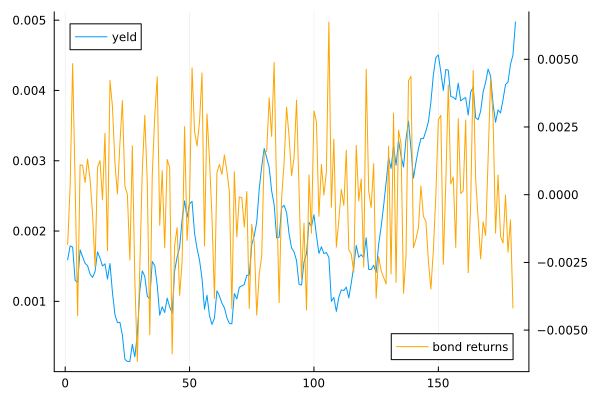

In [291]:
scenario = 3
plot(yelds10y[scenario,:], label="yeld")
plot!(twinx(), bond_returns[scenario,:], label="bond returns", color=:orange)

In [292]:
sim = rand(Normal(.08, .16), 100_000)
quantile(sim, [.05, .25, .5, .75, .95])

5-element Vector{Float64}:
 -0.18283249993623424
 -0.02783906206173233
  0.0810291308947121
  0.18761014586398314
  0.34129254385438446

In [293]:
sim = rand(Normal(.08, .16), 100_000)
quantile(sim, [.05, .25, .5, .75, .95])

5-element Vector{Float64}:
 -0.18069296424448528
 -0.026885532937763093
  0.08126887987807355
  0.18846597892676548
  0.3432909949441148

In [297]:
simt = rand(LocationScale(.04, .075, TDist(2.5)), 100_000)
quantile(simt, [.02, .25, .5, .75, .98])

5-element Vector{Float64}:
 -0.25871413744639427
 -0.019262202047420858
  0.039815189179934846
  0.09954183795558116
  0.33847013436539075